# 1. Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pickle
import lipd
plt.style.use('ggplot') 

#matplotlib inLine
%config InlineBackend.figure_format = 'retina'

# 2. Loading the CoralHydro2k database

In [2]:
# Declare working directory (location of .pkl file)
data_dir = '/Users/ross_ong_amnh/Documents/CoralHydro2K/' 

# Declare latest database version
version  = '1_0_0'

file_to_open = open(data_dir + 'CoralHydro2k' + version + '.pkl','rb')
proxies_all  = pickle.load(file_to_open)['D']
file_to_open.close()

# Extract the time series 
# Example 1. Extract Sr/Ca records in the Pacific Ocean under group 1
all_TS      = lipd.extractTs(proxies_all)
filtered_TS = lipd.filterTs(all_TS, 'geo_ocean == Pacific Ocean')
filtered_TS = lipd.filterTs(filtered_TS, 'paleoData_coralHydro2kGroup == 1')
filtered_TS = lipd.filterTs(filtered_TS, 'paleoData_variableName == SrCa')
n_proxies   = len(filtered_TS)

extracting paleoData...
extracting: KA17RYU01
extracting: CH18YOA02
extracting: FL17DTO02
extracting: BO14HTI01
extracting: AB20MEN01
extracting: DR99ABR01
extracting: OS13NLP01
extracting: ZI04IFR01
extracting: CH18YOA01
extracting: FL17DTO01
extracting: SA16CLA01
extracting: AB20MEN03
extracting: TU01DEP01
extracting: BO14HTI02
extracting: AB20MEN02
extracting: CO00MAL01
extracting: SW98STP01
extracting: AB20MEN06
extracting: AB08MEN01
extracting: RE18CAY01
extracting: HE13MIS02
extracting: CA13SAP01
extracting: MO06PED01
extracting: AB20MEN07
extracting: DR00NBB01
extracting: ZI16ROD01
extracting: DR00KSB01
extracting: ZI15MER01
extracting: NU09KIR01
extracting: KU00NIN01
extracting: PF19LAR01
extracting: AB20MEN05
extracting: HE13MIS01
extracting: HE10GUA01
extracting: EV18ROC01
extracting: AB20MEN04
extracting: CA07FLI01
extracting: SH92PUN01
extracting: ZI16ROD02
extracting: RA20TAI01
extracting: CH03BUN01
extracting: MU18RED02
extracting: TU01LAI01
extracting: NU11PAL01
extracti

## Suggested keys for filtering:

 - Group (see Table 1 in database descriptor): 'paleoData_coralHydro2kGroup'
 - Proxy Type (SrCa, d18O, d18Osw): 'paleoData_variableName'
 - Temporal Coverage:
   - minYear (record start year)
   - maxYear (record end year)
 - Record Resolution:
   - paleoData_hasResolution_hasMinValue (minimum resolution in units of 'Years CE'
   - paleoDate_hasResolution_hasMaxValue (maximum resolution)
   - paleoData_hasResolution_hasMeanValue (mean resolution)
   - paleoData_hasResolution_hasMedianValue (median resolution)

 - Location:
   - geo_latitude  (record latitude; units: degrees N)
   - geo_longitude (record longitude; units: degrees E)
   - geo_siteName  (name of the site/location)
   - geo_ocean     (ocean basin of the coral record)
- Species: 'paleoData_archiveSpecies'

In [3]:
# Checking for keys
all_TS[0].keys()

dict_keys(['mode', 'time_id', 'additionalDataUrl', 'archiveType', 'context', 'createdBy', 'datasetId', 'dataSetName', 'lipdverseLink', 'maxYear', 'minYear', 'originalDataUrl', 'changelog', 'pub1_author', 'pub1_citation', 'pub1_doi', 'pub1_firstauthor', 'pub1_journal', 'pub1_title', 'pub1_year', 'pub2_author', 'pub2_citation', 'pub2_doi', 'pub2_firstauthor', 'pub2_journal', 'pub2_title', 'pub2_year', 'pub3_year', 'geo_meanLon', 'geo_meanLat', 'geo_meanElev', 'geo_type', 'geo_description', 'geo_ocean', 'geo_secondarySiteName', 'geo_siteName', '@context', 'lipdVersion', 'tableType', 'paleoData_tableName', 'paleoData_filename', 'paleoData_missingValue', 'year', 'yearUnits', 'paleoData_analyticalError', 'paleoData_analyticalErrorUnits', 'paleoData_archiveSpecies', 'paleoData_ch2kCoreCode', 'paleoData_coralExtensionRate', 'paleoData_coralExtensionRateNotes', 'paleoData_coralHydro2kGroup', 'paleoData_isAnomaly', 'paleoData_isComposite', 'paleoData_jcpCorrected', 'paleoData_jcpMeasured', 'pale

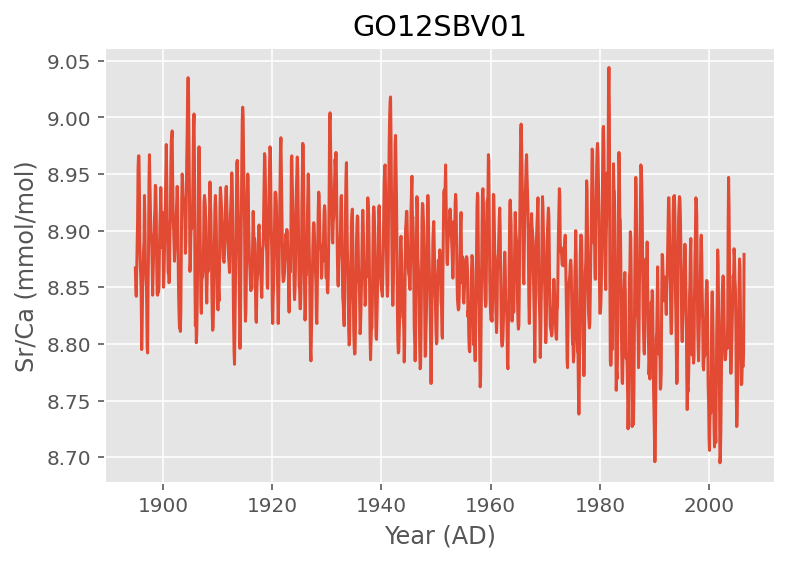

In [4]:
# Example 2. Quick way to get and visualize data
# Get data
index_chosen = 8
proxy_data   = np.array(filtered_TS[index_chosen]['paleoData_values']).astype(float)
proxy_ages   = np.array(filtered_TS[index_chosen]['year']).astype(float)
dataset_name = filtered_TS[index_chosen]['dataSetName']

# Make a simple figure
plt.plot(proxy_ages,proxy_data)
plt.xlabel('Year ('+filtered_TS[index_chosen]['yearUnits']+')')
plt.ylabel('Sr/Ca ('+filtered_TS[index_chosen]['paleoData_units']+')')
plt.title(dataset_name)
plt.show()

# 3. Plotting a global map to visualize data

In [5]:
# Create empty arrays to store the lats and lons
lats_all = np.zeros(len(all_TS)); lats_all[:] = np.nan
lons_all = np.zeros(len(all_TS)); lons_all[:] = np.nan

# Loop through all proxy records, storing the lats and lons in the newly-created arrays
for i in range(len(all_TS)):
    lats_all[i] = all_TS[i]['geo_meanLat']
    lons_all[i] = all_TS[i]['geo_meanLon']

In [6]:
# A function to make a map of all proxy locations in a given region 
def proxy_map(map_bounds):
    #
    # Count the number of proxy records in this region 
    n_selected = len(np.where((lons_all >= map_bounds[0]) & (lons_all <= map_bounds[1]) & (lats_all >= map_bounds[2]) & (lats_all <= map_bounds[3]))[0])
    #
    # Plot the locations of all proxy records in the region
    plt.figure(figsize=(12,20))
    ax1 = plt.subplot2grid((1,1),(0,0),projection=ccrs.PlateCarree()); ax1.set_extent(map_bounds,crs=ccrs.PlateCarree())
    ax1.scatter(lons_all,lats_all,25,c='purple',marker='o',alpha=1,transform=ccrs.PlateCarree())
    ax1.coastlines()
    ax1.gridlines(color='k',linestyle='--',draw_labels=True)
    ax1.set_title('Locations of all proxy records in the CoralHydro2K database',fontsize=14,loc='center')
    plt.show()

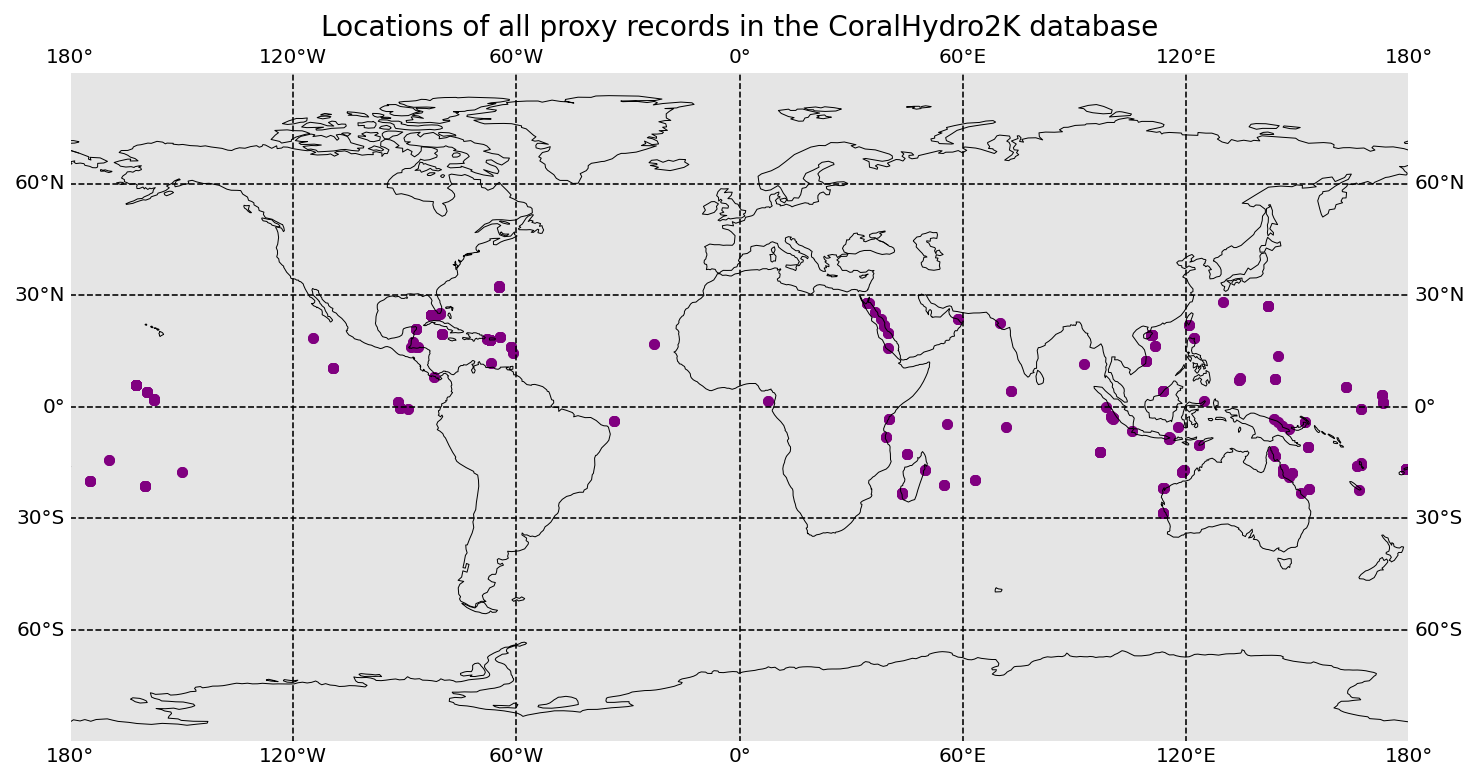

In [7]:
proxy_map([-180,180,-90,90])